In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot

from load_data import load_financial_data, load_sentiment_data
from models import confusion_matrix, compute_metrics
from preprocessing import merge_sentiment_financials
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Using TensorFlow backend.


In [3]:
# Create Logger, Model checkpointing, Live plot etc
import keras
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras_tqdm import TQDMNotebookCallback
from IPython.display import clear_output

model_name = 'randomforest'
# create csv logger
csv_logger = CSVLogger('models_logs/' + model_name + '.log')

# use early stopping
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 10,
                               verbose = 0,
                               mode = 'auto')

# we also use model checkpointing
filepath = 'models_logs//' + model_name + '.hdf5'
checkpointer = ModelCheckpoint(filepath, 
                               monitor = 'val_loss', 
                               verbose = 0, 
                               save_best_only = True, 
                               mode = 'min')
# LR scheduler
scheduler = ReduceLROnPlateau(factor = 0.1, patience=3, min_lr = 0.000001, verbose = 1)

# fancy progress bar
progress_bar = TQDMNotebookCallback(leave_inner = True, leave_outer = True)

# function to plot loss and accuracy live
class learning_plot(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plot.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs = {}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plot.subplots(1, 2, sharex = True)
        
        clear_output(wait = True)
        
        #ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label = 'loss')
        ax1.plot(self.x, self.val_losses, label = 'val_loss')
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label = 'accuracy')
        ax2.plot(self.x, self.val_acc, label = 'validation accuracy')
        ax2.legend()
        
        plot.show();

plot_losses = learning_plot()

# construct callback list
my_callbacks = [csv_logger, early_stopping, checkpointer, scheduler, progress_bar, plot_losses]

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
# # MULTIVARIATE BINARY

In [5]:
# Load Data
df_financials = load_financial_data(filepath = 'data/top20_aggre_price_reduced.csv', start_date = '2017-07-28', end_date = '2018-07-27', tickers = 'BTC')
df_sentiment = load_sentiment_data(filepath = 'data/BTC_sentiment_aggr_shifted.csv', start_date = '2017-07-28', end_date = '2018-07-27')
# Merge the data
df_merged = merge_sentiment_financials(df_financials, df_sentiment)

In [6]:
# Get different values for BTC (log, diff, combination)

# Diff
df_merged['BTC_diff'] = df_merged['BTC']-df_merged['BTC'].shift()


# Log
df_merged['BTC_log']= np.log(df_merged['BTC'])

# Diff of log
df_merged['BTC_log_diff'] = df_merged['BTC_log']-df_merged['BTC_log'].shift()

# Drop empty rows which were created through diff
df_merged.dropna(inplace = True)

# Make financial data binary (rise: 1/not rise: 0)
df_merged['BTC_bin'] = np.sign(df_merged['BTC_diff'])
df_merged['BTC_bin'] = df_merged['BTC_bin'].replace(to_replace = -1, value = 0)



In [7]:
#Fill missing values with the ffill method
df_merged['amount_of_tweets'] = df_merged['amount_of_tweets'].replace(to_replace=0, method = 'ffill')
df_merged['sentiment'] = df_merged['sentiment'].replace(to_replace=0, method = 'ffill')
df_merged['weighted_sentiment'] = df_merged['weighted_sentiment'].replace(to_replace=0, method = 'ffill')

In [17]:
in_seq1 = df_merged['BTC_bin'].values
in_seq2 = df_merged['weighted_sentiment'].values
in_seq3 = df_merged['amount_of_tweets'].values
out_seq = df_merged['BTC_bin'].shift(-1).values

In [18]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, in_seq3, out_seq))
# remove nans
dataset = dataset[~np.isnan(dataset).any(axis=1)]

In [19]:
# Split the sequences
n_steps = 24
n_features = 3
X, y = split_sequences(dataset, n_steps)

In [20]:
# train / val split
my_train_prop = 0.66
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  train_size = my_train_prop, test_size  = 1 - my_train_prop, 
                                                  random_state = 1)

In [21]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 23, 64)            448       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 704)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                35250     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 35,749
Trainable params: 35,749
Non-trainable params: 0
_________________________________________________________________


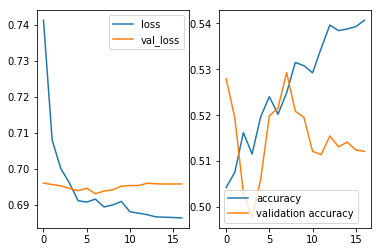

In [23]:
#model.fit(X_train, y_train, epochs=20, verbose=1)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, verbose=0, callbacks=my_callbacks)

In [25]:
my_pred = model.predict(X_val).round().astype('int').reshape(1,2970).flatten()
my_ground_truth = y_val.astype('int')

In [26]:
conf_mat = confusion_matrix(my_pred, my_ground_truth)
precision, recall, accuracy = compute_metrics(conf_mat)

Confusion Matrix: 
[[  263.  1165.]
 [  284.  1258.]]
Precision: 0.519191085431
Recall: 0.815823605707
Accuracy: 0.512121212121


In [ ]:
# UNIVARIATE BINARY

In [27]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, out_seq))
# remove nans
dataset = dataset[~np.isnan(dataset).any(axis=1)]

In [37]:
# Split the sequences
n_steps = 24
n_features = 1
X, y = split_sequences(dataset, n_steps)

In [46]:
# train / val split
my_train_prop = 0.66
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  train_size = my_train_prop, test_size  = 1 - my_train_prop, 
                                                  random_state = 1)

In [47]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 23, 64)            192       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 704)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                35250     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 35,493
Trainable params: 35,493
Non-trainable params: 0
_________________________________________________________________


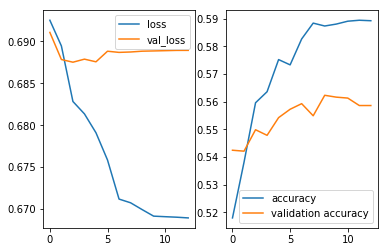

In [48]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, verbose=0, callbacks=my_callbacks)

In [49]:
my_pred = model.predict(X_val).round().astype('int').reshape(1,2970).flatten()
my_ground_truth = y_val.astype('int')

In [50]:
conf_mat = confusion_matrix(my_pred, my_ground_truth)
precision, recall, accuracy = compute_metrics(conf_mat)

Confusion Matrix: 
[[ 685.  743.]
 [ 568.  974.]]
Precision: 0.567268491555
Recall: 0.631647211414
Accuracy: 0.558585858586


In [36]:
# UNIVARIATE with only SENTIMENT as input
# convert to [rows, columns] structure
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq2, out_seq))
# remove nans
dataset = dataset[~np.isnan(dataset).any(axis=1)]

In [45]:
# MULTIVARIATE with sentiment and BTC_bin
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
#in_seq3 = in_seq3.reshape((len(in_seq3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# remove nans
dataset = dataset[~np.isnan(dataset).any(axis=1)]

# Split the sequences
n_steps = 24
n_features = 2
X, y = split_sequences(dataset, n_steps)